In [265]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
import scipy.stats as st
import statsmodels.stats.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import ttest_1samp

pd.set_option('display.max_columns', 500)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

After clustering the customers in ``clustering_analysis.ipynb``, we explore this segmentation with the following null hypothesis:

$H_0$: in the 2 clustering scenario, the cluster with customers with higher average income will deal a higher number of times with the company in long term

An alternative hypothesis $H_1$ is a negative of $H_0$, in other words this customer group is not dealing with the company more than any group under some statistical significance applied in our test.

In [21]:
data_cleaned = pd.read_csv('dataset/cleaned_marketing_campaign.csv', sep=',')
data_cleaned.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Accepted
0,0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,...,4,7,0,0,0,0,0,0,1,0
1,1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,...,2,5,0,0,0,0,0,0,0,0
2,2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,...,10,4,0,0,0,0,0,0,0,0
3,3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,...,4,6,0,0,0,0,0,0,0,0
4,4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,...,6,5,0,0,0,0,0,0,0,0


In [26]:
data_cleaned['Accepted'].value_counts()

0    1747
1     322
2      81
3      44
4      11
Name: Accepted, dtype: int64

In [32]:
data_cleaned['Accepted'] = (data_cleaned['Accepted'] != 0).astype(int)

In [34]:
data_cleaned['Accepted'].value_counts()

0    1747
1     458
Name: Accepted, dtype: int64

In [69]:
m,n = data_cleaned.shape
SE = st.sem(data_cleaned['Accepted'])
SE = np.std(data_cleaned['Accepted'])/np.sqrt(m)
mean = np.mean(data_cleaned['Accepted'])

t_value = st.t.ppf(q=0.99, df=m-1)

CI = mean - t_value * SE, mean + t_value * SE
print('Confidence Interval for the whole dataset:', CI)

Confidence Interval for the whole dataset: (0.18759767337763758, 0.22782182775614926)


In [68]:
y_pred = np.load('dataset/prediction_2_clusters.npy')
np.unique(y_pred)

array([0, 1])

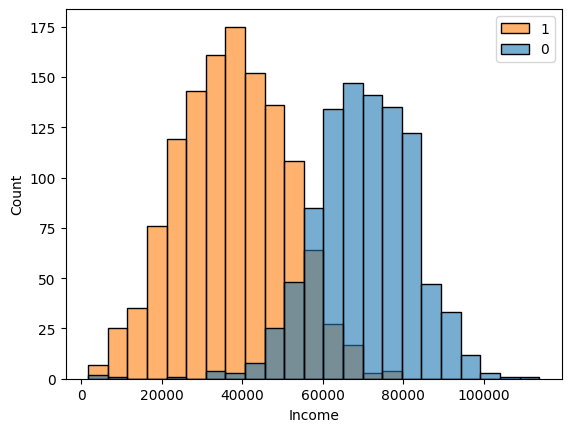

In [107]:
sn.histplot(data=data_cleaned, hue=y_pred, x='Income', alpha=0.6)
plt.legend(labels=[1,0])
plt.show()

In [116]:
accep_0 = data_cleaned.iloc[y_pred == 0]['Accepted'] #higher income
accep_1 = data_cleaned.iloc[y_pred == 1]['Accepted'] #lower income

print(accep_0.value_counts())
print(accep_1.value_counts())

print('Acceptance rate for cluster 0: %.2f%%'%(100 * (accep_0 == 1).astype(int).sum()/(accep_0 == 0).astype(int).sum()))
print('Acceptance rate for cluster 1: %.2f%%'%(100 * (accep_1 == 1).astype(int).sum()/(accep_1 == 0).astype(int).sum()))

0    629
1    324
Name: Accepted, dtype: int64
0    1118
1     134
Name: Accepted, dtype: int64
Acceptance rate for cluster 0: 51.51%
Acceptance rate for cluster 1: 11.99%


In [121]:
m,n = data_cleaned.shape

mean_0 = np.mean(accep_0)
mean_1 = np.mean(accep_1)

SE_0 = st.sem(accep_0)

t_value = st.t.ppf(q=0.99, df=m-1)

CI_0 = mean_0 - t_value * SE_0, mean_0 + t_value * SE_0
print('Confidence Interval for the whole dataset:', CI_0)
print('Mean value of acceptances of cluster 1:', mean_1)

Confidence Interval for the whole dataset: (0.30423715940279245, 0.37572086787947406)
Mean value of acceptances of cluster 1: 0.10702875399361023


We then reject the null hypothesis $H_0$ with 99% C.L., since the mean of the cluster 1 does not fall into the CI from cluster 0.

Let us check with other approach using the p-value. We need to establish some parameters to accomplish the A/B test procedure:

- **Power of the test** ($1 - \beta$): This is the probability of successfully predict that both customer cluster differs in Accepted Rate defined in the dataset, when they actually are different. We set it as 99%.
- **Significance** ($\alpha$): The probability of performing a hypothesis test with result out of the defined confidence level. We set it as 1%.
- **Effect size**: Can be calculated using the above metrics, and provides how both clusters would differ given some expected (or desired) change in the rate.

In [257]:
effect_size = sm.proportion_effectsize(0.1199, 0.5151)
power_ = 0.99
alpha_ = 0.01

effect_size

-0.893825491622076

In [249]:
required_n = sm.NormalIndPower().solve_power(
    effect_size,
    power=power_,
    alpha=alpha_,
    ratio=1
    )
required_n = int(np.ceil(required_n))
required_n

61

In [250]:
control_sample = data_cleaned.iloc[y_pred == 0].sample(required_n)
treatment_sample = data_cleaned.iloc[y_pred == 1].sample(required_n)

In [251]:
i_con = control_sample.index
i_trea = treatment_sample.index

In [252]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)

In [253]:
control_results = ab_test.loc[i_con]['Accepted']
treatment_results = ab_test.loc[i_trea]['Accepted']

In [254]:
successes = [control_results.sum(), treatment_results.sum()]
nobs = [control_results.count(), treatment_results.count()]

In [261]:
z_stat, pvalue = proportions_ztest(successes, nobs=nobs)
(lower_control, lower_treat), (upper_control, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=alpha_)

print(pvalue)
print((lower_control, lower_treat), (upper_control, upper_treat))

0.05041955573335427
(0.09082134999499744, 0.0001453219375038145) (0.36819504344762555, 0.196575989537906)


Now, we will perform the above test 10,000 times but for samples with 100 size, in order to check if p-values generally lies before the threshold impossed by $\alpha$:

In [297]:
p_value_list = []
required_n = 100

for i in range(10000):
    control_sample = data_cleaned.iloc[y_pred == 0].sample(required_n)
    treatment_sample = data_cleaned.iloc[y_pred == 1].sample(required_n)

    i_con = control_sample.index
    i_trea = treatment_sample.index

    ab_test = pd.concat([control_sample, treatment_sample], axis=0)

    control_results = ab_test.loc[i_con]['Accepted']
    treatment_results = ab_test.loc[i_trea]['Accepted']

    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [control_results.count(), treatment_results.count()]

    z_stat, p_value = proportions_ztest(successes, nobs=nobs)
    (lower_control, lower_treat), (upper_control, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=alpha_)

    p_value_list.append(p_value)

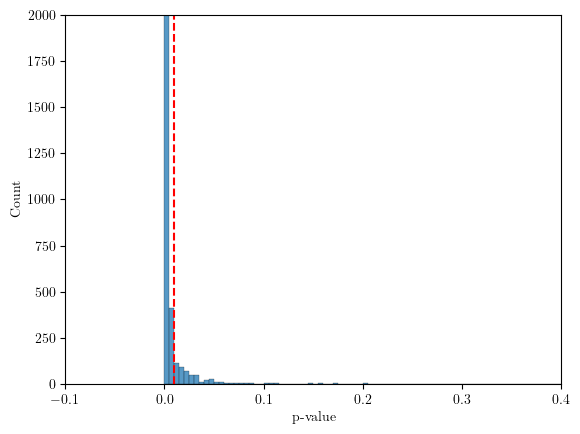

In [298]:
ax = sn.histplot(x=p_value_list, bins=200)
ax.set_xlabel(r'p-value')
ax.set_xlim(-0.1,0.4)
ax.axvline(alpha_, linestyle='--', color='r')
ax.set_ylim(0,2000)
plt.show()

In [300]:
print(f'Percentage of p-values below the alpha threshold: {100 * (np.array(p_value_list) < alpha_).sum()/len(p_value_list)}%')

Percentage of p-values below the alpha threshold: 94.25%


It shows that we can exclude the null hypothesis with more confidence, then customers from the cluster 0 tend to be converted with a good level of confidence.